In [1]:
import pandas as pd
import numpy as np
import pickle
from StringContains import ContainedStringCase 
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
import os
from scipy.stats import ks_2samp, ttest_rel, f, mannwhitneyu, pearsonr, spearmanr, kendalltau
from jmh_parser import parseFile
from benchmarkutils import get_data_frame_from_csv, get_ks_2sample_test_log, get_mann_whitney_u_test_test_log, read_log
from statsmodels.formula.api import ols
import statsmodels.api as sm
import glob
import math

In [2]:
output_dir = "http_stringDataset/"
df = pd.read_csv(output_dir + "http_0.9_49.csv")
files = glob.glob(output_dir + "*[0-9].csv", recursive=False)
print(len(files))
df

250


,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit,Param: json_filename,Param: regex
0,benchmark.StringContainsDataset.regexMatches,avgt,1,100,1.208035e+06,44745.786044,ns/op,http_0.9_49.json,http
1,benchmark.StringContainsDataset.stringContains,avgt,1,100,5.300281e+04,403.185847,ns/op,http_0.9_49.json,http


In [9]:
def getStd(file_path):
    t = parseFile(file_path)
    t = t.loc[t["Iteration Type"]=="measured",:]
    t = t.astype({"Score":"float"})
    return {"regexMatches": t.loc[t["Method"] =="regexMatches","Score"].std(), "stringContains": t.loc[t["Method"] !="regexMatches","Score"].std()}
def get_data_frame_from_csv(output_dir: str):
    files = glob.glob(output_dir + "*[0-9].csv", recursive=False)
    data = []
    for file_name in files:
        *regex, match_ratio, sample = file_name[:-4].split("_")
        df = pd.read_csv(file_name)
        df = df.loc[:, ["Benchmark", "Score", "Score Error (99.9%)"]]
        df['Benchmark'] = df["Benchmark"].map(lambda x: x.split(".")[-1])
        df['sample'] = sample
        df['match_ratio'] = match_ratio
        df['Score_int'] = df['Score'].round().astype(int) ## Score from float to int
        
        file_log = file_name[:-4]+".log"
        stds = getStd(file_log)
        df.loc[df["Benchmark"] == "regexMatches", "standard deviation"] = stds["regexMatches"]
        df.loc[df["Benchmark"] == "stringContains", "standard deviation"] = stds["stringContains"]

        data.append(df)
        
    df = pd.concat(data, ignore_index=True)
#     df = df.pivot_table(values = ["Score", "Score_int", 'Score Error (99.9%)'], index=["str_len","match_pos_ratio", "sample", "Score_int"], columns="Benchmark")
#     return df
#     df.reset_index(drop=False, inplace=True) 
#     df['improve_ratio'] = df["regexMatches"] / df['stringContains']
    return df

In [12]:
df = get_data_frame_from_csv(output_dir)
df

,Benchmark,Score,Score Error (99.9%),sample,match_ratio,Score_int,standard deviation
0,regexMatches,1.734077e+06,47505.076190,19,0.1,1734077,140069.798953
1,stringContains,4.469083e+04,322.445378,19,0.1,44691,950.737592
2,regexMatches,1.831305e+06,11757.068623,31,0.1,1831305,34665.984569
3,stringContains,4.766173e+04,484.003048,31,0.1,47662,1427.094018
4,regexMatches,1.991145e+06,57931.664755,25,0.1,1991145,170812.832828
...,...,...,...,...,...,...,...
495,stringContains,4.552751e+04,451.781624,28,0.1,45528,1332.088467
496,regexMatches,1.931114e+06,30646.557893,7,0.1,1931114,90362.073845
497,stringContains,4.745568e+04,554.410800,7,0.1,47456,1634.692853
498,regexMatches,1.784034e+06,49403.958895,14,0.1,1784034,145668.697861


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Benchmark            500 non-null    object 
 1   Score                500 non-null    float64
 2   Score Error (99.9%)  500 non-null    float64
 3   sample               500 non-null    object 
 4   match_ratio          500 non-null    object 
 5   Score_int            500 non-null    int64  
 6   standard deviation   500 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 27.5+ KB


In [18]:
df["Score_log2"] = df['Score'].apply(lambda x: math.log2(x))

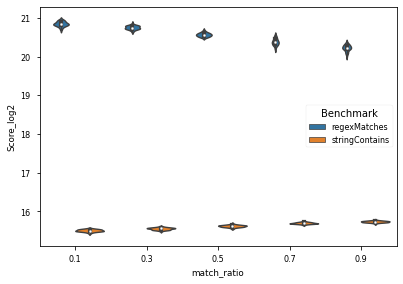

In [30]:
ax = sns.violinplot(x="match_ratio", y="Score_log2",
            hue="Benchmark", 
            data=df)

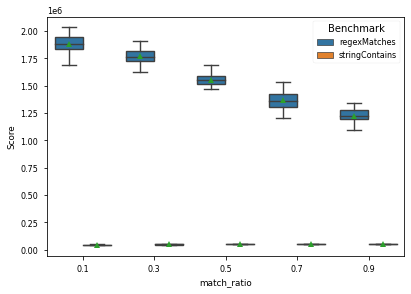

In [23]:
ax = sns.boxplot(x="match_ratio", y="Score",
            hue="Benchmark", 
            data=df, showmeans=True,showfliers=False)

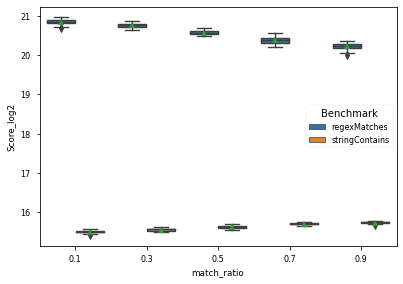

In [22]:
ax = sns.boxplot(x="match_ratio", y="Score_log2",
            hue="Benchmark", 
            data=df, showmeans=True)

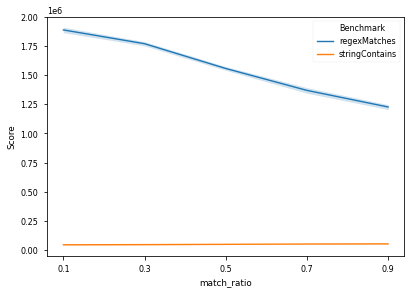

In [46]:
ax = sns.lineplot(x="match_ratio", y="Score",
            hue="Benchmark", 
            data=df)

In [40]:
t = df.pivot_table(values = ["Score","Score Error (99.9%)","Score_int"], index=["sample", "match_ratio"], columns="Benchmark")
t.reset_index(drop=False, inplace=True) 
t

sample match_ratio         Score                Score Error (99.9%)  \
Benchmark                     regexMatches stringContains        regexMatches   
0              0         0.1  1.940429e+06   47560.626197        41224.965278   
1              0         0.3  1.711295e+06   48285.129294        25855.297965   
2              0         0.5  1.573614e+06   50165.612673        32449.228444   
3              0         0.7  1.470848e+06   53794.736655        31193.864233   
4              0         0.9  1.292062e+06   56409.432944        12920.122910   
..           ...         ...           ...            ...                 ...   
245            9         0.1  1.903571e+06   47594.354372        16317.994584   
246            9         0.3  1.829400e+06   49265.028131        16868.182098   
247            9         0.5  1.587096e+06   50897.613667        10719.645699   
248            9         0.7  1.448817e+06   53879.298306        30754.559615   
249            9         0.9  1.258180e+06   55672.917270        34605.832732   

                            Score_int                 
Benchmark stringContains regexMatches stringContains  
0             370.842182      1940429          47561  
1             573.723688      1711295          48285  
2             514.353193      1573614          50166  
3             295.887469      1470848          53795  
4             363.374388      1292062          56409  
..                   ...          ...            ...  
245           586.796728      1903571          47594  
246           588.131516      1829400          49265  
247           463.590714      1587096          50898  
248           484.591287      1448817          53879  
249           541.331978      1258180          55673  

[250 rows x 8 columns]

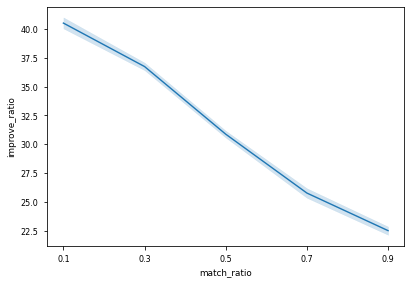

In [41]:
t["improve_ratio"] = t["Score"]["regexMatches"] / t["Score"]["stringContains"]
sns.lineplot(data=t, x="match_ratio", y="improve_ratio")

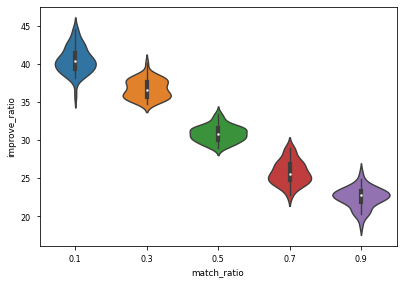

In [43]:
sns.violinplot(data=t, x="match_ratio", y="improve_ratio")

In [38]:
t['improve_ratio'].describe()

count    250.000000
mean      31.280604
std        6.839617
min       18.793217
25%       24.789950
50%       30.809145
75%       37.620641
max       44.520343
Name: improve_ratio, dtype: float64

In [31]:
df['relative std'] = df['standard deviation'] / df['Score']

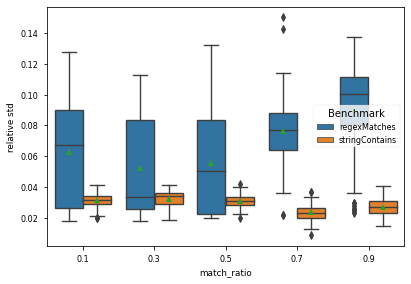

In [34]:
sns.boxplot(data = df, x="match_ratio", y="relative std", hue = "Benchmark", showmeans = True)

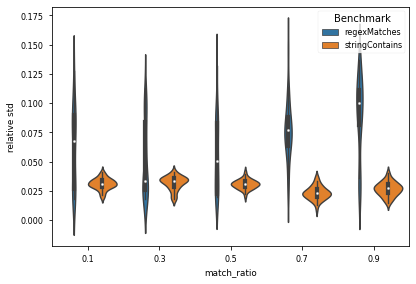

In [37]:
sns.violinplot(data = df, x="match_ratio", y="relative std", hue = "Benchmark", showmeans = True)